In [1]:
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
import uproot
import numpy as np
import awkward as ak
from torch.utils.data import DataLoader
import torch
import datetime
import numpy as np
import torch
import torch.nn as nn 
import math
from torch import nn, Tensor
from torch.utils.data import Dataset
import torch.nn as nn 
from torch import nn, Tensor
import torch.nn.functional as F
import awkward as ak

In [2]:
import uproot
### Energy = 0.15 GeV
root_file1 = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/outputPSWithPU_withNoise_0.150000_0.15_19Nov_VF1.root")
root_file2 = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/outputPSWithPU_withNoise_0.150000_0.15_19Nov_VF2.root")
tree1 = root_file1["Samples"]
tree2 = root_file2["Samples"]
arrays1 = tree1.arrays(["samples", "ysamples","samplesNoise","ysamplesNoise"])
arrays2 = tree2.arrays(["samples", "ysamples","samplesNoise","ysamplesNoise"])
X_real = ak.to_numpy(arrays1["samples"])
X_real = X_real/np.max(X_real, axis = 1).reshape(200000,1)
y_real = ak.to_numpy(arrays1["ysamples"])
X_noise = ak.to_numpy(arrays2["samplesNoise"])
X_noise = X_noise/np.max(X_noise, axis = 1).reshape(200000,1)
y_noise = ak.to_numpy(arrays2["ysamplesNoise"])

print(X_real) 
print("Printing y_real")
print(y_real)

data = np.concatenate([X_real, X_noise]) ### makes it [2*num_events,num_samples]
labels = np.concatenate([y_real, y_noise])


# Shuffle data and labels together
## Important to shuffle since I take some fraction of events so it should not happen that all the real events 
## are cluttered at the beginning

shuffle_indices = np.random.permutation(len(data))
data = data[shuffle_indices]
labels = labels[shuffle_indices]

[[-2.18991428 -1.33758012 -0.16379419 ...  0.97133729  0.38098346
  -1.97539871]
 [-0.02620282  0.3494965   0.54694886 ...  0.55314748  0.19741884
  -0.15557223]
 [ 0.70501369  0.95452037  1.         ...  0.82044019  0.71309163
   0.61413221]
 ...
 [-0.03224206 -0.11911494  0.25985249 ...  0.45905995  0.7742844
   1.        ]
 [ 0.42559843  0.71037992  0.30653368 ...  0.96303223  1.
   0.64932407]
 [-0.13804387  0.03573051 -0.07850811 ...  0.81263918  0.81864257
   0.44620173]]
Printing y_real
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [3]:
import awkward as ak

num_events_data = ak.num(data, axis=0)
print(f'number of rows in data is {num_events_data}')


ntimeSamples_data = ak.num(data, axis=1)
print(f'number of rows in data is {ntimeSamples_data[0]}') ## just take the 0th event

# Split into train and test sets
train_size = int(0.7 * num_events_data) ###times 2 because the noise is also in the same dataset, so it is 2*num_events
valid_size = train_size + int(0.1 * num_events_data)
train_data = data[:train_size]
train_labels = labels[:train_size]
valid_data = data[train_size:valid_size]
valid_labels = labels[train_size:valid_size]
test_data = data[valid_size:]
test_labels = labels[valid_size:]

print(f'Size of training data is {train_size}')

'''
print(train_size)
print(train_data)
print(test_data)
'''

print(f'number of elements in data : training data : test data : validation data: {len(data)} : {len(train_data)} : {len(test_data)} : {len(valid_data)}')

number of rows in data is 400000
number of rows in data is 10
Size of training data is 280000
number of elements in data : training data : test data : validation data: 400000 : 280000 : 80000 : 40000


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)

device: cuda


In [5]:
train_data = train_data.reshape((train_data.shape[0], train_data.shape[1], 1))
test_data = test_data.reshape((test_data.shape[0], test_data.shape[1], 1))
valid_data = valid_data.reshape((valid_data.shape[0], valid_data.shape[1], 1))
train_labels = train_labels.reshape((train_labels.shape[0], 1))
test_labels = test_labels.reshape((test_labels.shape[0], 1))
valid_labels = valid_labels.reshape((valid_labels.shape[0], 1))

In [6]:
train_data = torch.tensor(train_data, dtype =torch.float).to(device)
test_data = torch.tensor(test_data, dtype =torch.float).to(device)
valid_data = torch.tensor(valid_data, dtype =torch.float).to(device)
train_labels = torch.tensor(train_labels, dtype =torch.float).to(device)
test_labels = torch.tensor(test_labels, dtype =torch.float).to(device)
valid_labels = torch.tensor(valid_labels, dtype =torch.float).to(device)

In [7]:
class ClassifierDataset(Dataset):
    """
    Dataset class used for classifier models.
    
    """
    def __init__(self, 
        data: torch.tensor,
        lebel: torch.tensor
        ) -> None:
        
        super().__init__()

        self.data = data
        self.lebel = lebel

        print("data size = {}".format(data.size()))
        print("target size = {}".format(lebel.size()))
            

    def __len__(self):
        
        return self.data.size()[0]

    def __getitem__(self, index):
        """
        Returns a tuple with 3 elements:
        1) src (the encoder input)
        2) trg (the decoder input)
        3) trg_y (the target)
        """
        #print(self.data.size())
        data = self.data[index]
        lebel = self.lebel[index]
        return data, lebel

In [8]:
training_class = ClassifierDataset(
    data = train_data,
    lebel = train_labels)

data size = torch.Size([280000, 10, 1])
target size = torch.Size([280000, 1])


In [9]:
testing_class = ClassifierDataset(
    data = test_data,
    lebel = test_labels)

data size = torch.Size([80000, 10, 1])
target size = torch.Size([80000, 1])


In [10]:
validing_class = ClassifierDataset(
    data = valid_data,
    lebel = valid_labels)

data size = torch.Size([40000, 10, 1])
target size = torch.Size([40000, 1])


In [11]:
# Load the training data
training_dataloader = DataLoader(training_class, batch_size= 128)
# Load the testing data
testing_dataloader = DataLoader(testing_class, batch_size= 128)

In [12]:
class Classification_RNN(nn.Module):
    def __init__(self, input_size, hidden_dim1, hidden_dim2, hidden_dim3):
        super().__init__()
        self.rnn_1 = nn.LSTM(input_size, hidden_dim1, 1, bidirectional= True, batch_first= True)
        self.rnn_2 = nn.LSTM(2*hidden_dim1, hidden_dim2, 1, bidirectional= True, batch_first= True)
        #self.rnn_3 = nn.LSTM(2*hidden_dim2, hidden_dim3, 1, bidirectional= True, batch_first= True)
        self.fc = nn.Linear(2*hidden_dim2, input_size)
        self.fc1 = nn.Linear(10, input_size)
        self.activation = nn.Sigmoid()
        
    def forward(self, src):
        #print("Intial size",src.size())
        output, _ = self.rnn_1(src)
        #print("rnn_1 size",output.size())
        output, _ = self.rnn_2(output)
        #print("rnn_2 size",output.size())
        #output, _ = self.rnn_3(output)
        final_output = self.fc(output)
        #print("fc size",final_output.size())
        final_output = self.activation(final_output)
        final_output = torch.squeeze(final_output)
        #print("flatten size", final_output.size())
        final_output = self.fc1(final_output)
        #print("fc2 size", final_output.size())
        final_output = self.activation(final_output)
        return final_output

In [13]:
def create_model():
    input_size = 1
    hidden_dim1 = 16
    hidden_dim2 = 32
    hidden_dim3 = 64
 
    model = Classification_RNN(input_size, hidden_dim1, hidden_dim2, hidden_dim3)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.BCELoss()
 
    return model, optimizer, criterion

In [14]:
def train(training_dataloader, validing_dataloader, epochs = 10):
    
    model, optimizer, criterion = create_model()
    
    for epoch in range(1, epochs + 1):
        training_loss = []
        model.train()
        
        for i, (data, labels) in enumerate(training_dataloader):

            optimizer.zero_grad()

            output = model(data)

            loss = criterion(output, labels)
                        
            loss.backward()
            
            optimizer.step()
 
            training_loss.append(loss.item())
        
        print(f"At epoch {epoch} mean training loss is {torch.mean(torch.FloatTensor(training_loss))}")
        
        with torch.no_grad():
        
            model.eval()
            
            validation_loss = []
            
            for i, (data, labels) in enumerate(validing_dataloader):
            
                output = model(data)
                
                loss = criterion(output, labels)
                
                validation_loss.append(loss.item())
            
            print(f"At epoch {epoch} mean validation loss is {torch.mean(torch.FloatTensor(validation_loss))}")
             
    return model

In [15]:
model = train(training_dataloader, testing_dataloader, epochs = 20)

At epoch 1 mean training loss is 0.5574109554290771
At epoch 1 mean validation loss is 0.5042832493782043
At epoch 2 mean training loss is 0.505629301071167
At epoch 2 mean validation loss is 0.4992348551750183
At epoch 3 mean training loss is 0.5021129250526428
At epoch 3 mean validation loss is 0.4979434609413147
At epoch 4 mean training loss is 0.5000112056732178
At epoch 4 mean validation loss is 0.49662715196609497
At epoch 5 mean training loss is 0.4984607398509979
At epoch 5 mean validation loss is 0.49533891677856445
At epoch 6 mean training loss is 0.49723154306411743
At epoch 6 mean validation loss is 0.4941844642162323
At epoch 7 mean training loss is 0.49620679020881653
At epoch 7 mean validation loss is 0.49320268630981445
At epoch 8 mean training loss is 0.49536848068237305
At epoch 8 mean validation loss is 0.4922020137310028
At epoch 9 mean training loss is 0.49462199211120605
At epoch 9 mean validation loss is 0.49133017659187317
At epoch 10 mean training loss is 0.493

In [16]:
with torch.no_grad():
    model.eval()
    prediction = ()
    target = ()        
    for i, (data, labels) in enumerate(testing_dataloader):
        print(f"Step No. ---> {i}")
        output = model(data)        
        prediction += (output, )
        target += (labels, )

Step No. ---> 0
Step No. ---> 1
Step No. ---> 2
Step No. ---> 3
Step No. ---> 4
Step No. ---> 5
Step No. ---> 6
Step No. ---> 7
Step No. ---> 8
Step No. ---> 9
Step No. ---> 10
Step No. ---> 11
Step No. ---> 12
Step No. ---> 13
Step No. ---> 14
Step No. ---> 15
Step No. ---> 16
Step No. ---> 17
Step No. ---> 18
Step No. ---> 19
Step No. ---> 20
Step No. ---> 21
Step No. ---> 22
Step No. ---> 23
Step No. ---> 24
Step No. ---> 25
Step No. ---> 26
Step No. ---> 27
Step No. ---> 28
Step No. ---> 29
Step No. ---> 30
Step No. ---> 31
Step No. ---> 32
Step No. ---> 33
Step No. ---> 34
Step No. ---> 35
Step No. ---> 36
Step No. ---> 37
Step No. ---> 38
Step No. ---> 39
Step No. ---> 40
Step No. ---> 41
Step No. ---> 42
Step No. ---> 43
Step No. ---> 44
Step No. ---> 45
Step No. ---> 46
Step No. ---> 47
Step No. ---> 48
Step No. ---> 49
Step No. ---> 50
Step No. ---> 51
Step No. ---> 52
Step No. ---> 53
Step No. ---> 54
Step No. ---> 55
Step No. ---> 56
Step No. ---> 57
Step No. ---> 58
Step No

Step No. ---> 462
Step No. ---> 463
Step No. ---> 464
Step No. ---> 465
Step No. ---> 466
Step No. ---> 467
Step No. ---> 468
Step No. ---> 469
Step No. ---> 470
Step No. ---> 471
Step No. ---> 472
Step No. ---> 473
Step No. ---> 474
Step No. ---> 475
Step No. ---> 476
Step No. ---> 477
Step No. ---> 478
Step No. ---> 479
Step No. ---> 480
Step No. ---> 481
Step No. ---> 482
Step No. ---> 483
Step No. ---> 484
Step No. ---> 485
Step No. ---> 486
Step No. ---> 487
Step No. ---> 488
Step No. ---> 489
Step No. ---> 490
Step No. ---> 491
Step No. ---> 492
Step No. ---> 493
Step No. ---> 494
Step No. ---> 495
Step No. ---> 496
Step No. ---> 497
Step No. ---> 498
Step No. ---> 499
Step No. ---> 500
Step No. ---> 501
Step No. ---> 502
Step No. ---> 503
Step No. ---> 504
Step No. ---> 505
Step No. ---> 506
Step No. ---> 507
Step No. ---> 508
Step No. ---> 509
Step No. ---> 510
Step No. ---> 511
Step No. ---> 512
Step No. ---> 513
Step No. ---> 514
Step No. ---> 515
Step No. ---> 516
Step No. -

In [17]:
testing_hat = torch.cat(prediction)
testing_hat.size()

torch.Size([80000, 1])

In [18]:
testing_org = torch.cat(target)
testing_org.size()

torch.Size([80000, 1])

In [19]:
y_test = testing_org.data.cpu().numpy()

In [20]:
predictions = testing_hat.data.cpu().numpy()

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

test labels are: [0. 1. 1. ... 1. 0. 0.]
[[0.4261841 ]
 [0.28024694]
 [0.3678059 ]
 ...
 [0.15991512]
 [0.05599159]
 [0.39598197]]
[[0.57477397]
 [0.7346017 ]
 [0.86532605]
 ...
 [0.5547941 ]
 [0.7683646 ]
 [0.5341934 ]]


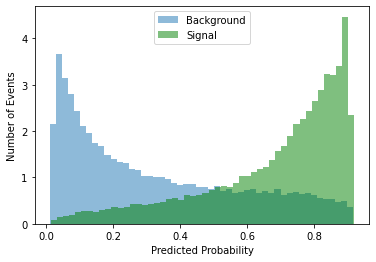

In [47]:
print(f'test labels are: {y_test[:,0]}')

# Create separate arrays for background and signal predictions
bkg_preds = predictions[y_test[:,0] == 0]
sig_preds = predictions[y_test[:,0] == 1]

print(bkg_preds)
print(sig_preds)
# Plot the predicted probabilities
plt.hist(bkg_preds, bins=50, label='Background', alpha=0.5, density=True)
plt.hist(sig_preds, bins=50, label='Signal', alpha=0.5, density=True, color='green')
plt.xlabel('Predicted Probability')
plt.ylabel('Number of Events')
plt.legend(loc='upper center')
plt.savefig("/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/Transformer/plots/Time_domain_Case1.png")
plt.show()

In [48]:
file = uproot.recreate("/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/Transformer/plots/Time_SigBkgCase1.root")

In [49]:
file['tree'] = { 
                    "True" : y_test,
                    "Prediction" : predictions
    }
file.close()

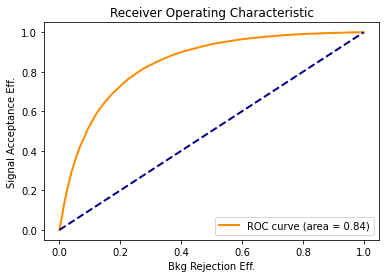

In [50]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Bkg Rejection Eff.')
plt.ylabel('Signal Acceptance Eff.')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.xlim([0.9, 1])
#plt.ylim([0.999, 1.005])
plt.savefig("/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/Transformer/plots/Time_Case1_ROC.png")
plt.show()

In [26]:
target = torch.from_numpy(y_test.flatten())
pred = torch.from_numpy(predictions.flatten())

In [27]:
from torchmetrics.classification import BinaryConfusionMatrix

In [28]:
metric = BinaryConfusionMatrix(threshold=0.7, normalize = 'true')(pred, target)
metric

tensor([[0.8757, 0.1243],
        [0.4051, 0.5949]])

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import awkward as ak
import uproot
from scipy.stats import norm
from scipy.optimize import curve_fit

In [30]:
num_samples=10
xmin = 0
xmax = 10
bdt_score_min = 0.7
events_to_read = -1

In [31]:
# Define the Gaussian function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * norm.pdf(x, mean, stddev)

In [32]:
def plot_timesamples(ax, time, emsignal_list, legTitle):
    #fig, ax = plt.subplots()
    #for i, emsignal in enumerate(emsignal_list):
    ax.plot(time, emsignal_list, label=f'{legTitle}')
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Amplitude (arb. units)')
   
    ax.legend()

In [34]:
# Open the ROOT file
#root_file = uproot.open(f"/eos/user/s/shilpi/SWAN_projects/ECAL_noise_EM_discrimination/data/timeSampleTree.root")
root_file = uproot.open(f"/eos/user/d/dasgupsu/SWAN_projects/ECAL_noise_EM_discrimination/data/timeSampleTree_alcareco.root")

# Access the tree containing the data
tree = root_file["timeSample/EventTreeEle"]

tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
eleE                 | double                   | AsDtype('>f8')
elePt                | double                   | AsDtype('>f8')
eleEta               | double                   | AsDtype('>f8')
elePhi               | double                   | AsDtype('>f8')
hitsAmplitudes       | std::vector<std::vect... | AsObjects(AsVector(True, As...
hitsEnergy           | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
hitsThr              | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
nsamples             | int32_t                  | AsDtype('>i4')
e5x5                 | double                   | AsDtype('>f8')
genPt                | double                   | AsDtype('>f8')
genEta               | double                   | AsDtype('>f8')
genPhi               | double                   | AsDtype('>f8')
genE      

In [35]:
# Get the number of entries in the TTree
num_entries = tree.num_entries
print(num_entries)

if(events_to_read==-1):
    events_to_read = num_entries

1973


In [36]:
# Read the needed branches into numpy arrays
arrays = tree.arrays(["elePt", "eleEta", "elePhi", "eleE", "e5x5",
                      "genPt", "genEta", "genPhi", "genE", "gendR",
                     "hitsEnergy", "hitsThr", "hitsAmplitudes"], entry_stop=events_to_read)

In [37]:
elePt = ak.to_numpy(arrays["elePt"])
eleEta = ak.to_numpy(arrays["eleEta"])
elePhi = ak.to_numpy(arrays["elePhi"])
eleE = ak.to_numpy(arrays["eleE"])
e5x5 = ak.to_numpy(arrays["e5x5"])
genPt = ak.to_numpy(arrays["genPt"])
genEta = ak.to_numpy(arrays["genEta"])
genPhi = ak.to_numpy(arrays["genPhi"])
genE = ak.to_numpy(arrays["genE"])
gendR = ak.to_numpy(arrays["gendR"])

In [38]:
# Convert the arrays to a vector of vector format
hitsAmpl = [np.array(arr) for arr in arrays["hitsAmplitudes"]]
hitsEn   = [np.array(arr) for arr in arrays["hitsEnergy"]]
hitsThr  = [np.array(arr) for arr in arrays["hitsThr"]]

In [39]:
energyDiff_pf_array = np.empty(0)
energyDiff_ps_array = np.empty(0)
totE_ps_array = np.empty(0)
e5x5_array = np.empty(0)
genE_array = np.empty(0)

In [40]:
nev=0
totE_ps = 0
for iev in hitsAmpl: ### icrys is ncrys times ntimesamples
    ncrys=0
    totE_ps = 0
    #print(iev)
    for icrys in iev: ## isample is array of ntimesamples
        icrys = icrys/np.max(np.abs(icrys))
        input_sample = np.reshape(icrys, (1, icrys.shape[0], 1))
        
        input_sample = torch.tensor(input_sample, dtype =torch.float).to(device)
        bdt_score = model(input_sample)
        bdt_score = bdt_score.data.cpu().numpy()
        #print(bdt_score)
        #print(hitsEn[nev][ncrys])
        #print(hitsThr[nev][ncrys])
        #print("------------------------------------------------------------")
        if(bdt_score > bdt_score_min):
            totE_ps = totE_ps + hitsEn[nev][ncrys]
        
        #print(f'Energy of this hit is {hitsEn[nev][ncrys]} AND threshold is {hitsThr[nev][ncrys]} .Now the BDT score {bdt_score}')
        ncrys=ncrys+1
    
    print(f'{genE[nev]}:{e5x5[nev]}:{totE_ps}')
    energyDiff_pf = (genE[nev] - e5x5[nev])/genE[nev]
    energyDiff_ps = (genE[nev] - totE_ps)/genE[nev]
    
    energyDiff_pf_array = np.append(energyDiff_pf_array, energyDiff_pf)
    energyDiff_ps_array = np.append(energyDiff_ps_array, energyDiff_ps)
    
    totE_ps_array = np.append(totE_ps_array, totE_ps)
    e5x5_array = np.append(e5x5_array, e5x5)
    genE_array = np.append(genE_array, genE)
    
    nev=nev+1    

print('==========================================================================')

63.903532126956414:37.86916732788086:40.34099880605936
2.148474743066199:3.5563931465148926:4.381317988038063
446.5083817808446:408.3748474121094:412.6176737844944
158.64052503288875:124.72956085205078:133.94837754964828
85.98826236271923:32.730804443359375:66.33806169778109
412.2307169797315:382.9134216308594:449.6469292640686
93.8538044183336:46.112274169921875:58.23833402991295
0.09280492267977951:0.5589107871055603:14.895897056907415
168.51379278570502:130.78016662597656:134.9638560116291
245.73594624469646:210.92349243164062:233.81979477405548
152.46408895851167:121.86319732666016:131.7093436717987
1.1359813811149624:14.368417739868164:17.740145444869995
274.6051309863256:226.58773803710938:267.2065838575363
101.39857264669513:64.4175033569336:80.367695055902
168.3375238329531:133.15809631347656:167.58680319786072
146.9338269373129:116.74507904052734:124.44689697865397
431.6658692732909:405.37603759765625:430.4186806678772
320.19232800291206:260.63470458984375:315.4798276424408
11

357.9643636518827:373.3341064453125:430.15301418304443
189.1718966630889:166.73036193847656:176.5662797987461
192.32869975286897:121.63412475585938:134.5442357957363
276.719600567862:219.6701202392578:240.73979890346527
11.674669332798608:12.155838966369629:13.14979176223278
318.27325648109667:262.0770568847656:27.520403265953064
184.18635165136791:155.30615234375:178.4350664615631
183.42127697051225:154.39712524414062:131.3194540143013
0.01496480273549902:252.32945251464844:300.9643737077713
28.640008101777624:114.71198272705078:119.6583227366209
128.78076345373086:108.70958709716797:113.00494286417961
25.977435853080685:21.7796630859375:22.78927592933178
122.72861350954352:132.95835876464844:161.73460936546326
56.98888347859622:43.690006256103516:44.71405407786369
304.12310523066225:276.76910400390625:323.9308789372444
318.83942435215073:229.7681121826172:297.13390588760376
295.8193049928775:297.2535705566406:331.12400805950165
196.50141714883358:171.09852600097656:177.2460367679596


143.95743829573286:46.879966735839844:86.93403905630112
89.90285676474919:71.96888732910156:74.6847703307867
71.28247684546534:49.838504791259766:54.17690788581967
115.5437222430419:92.186767578125:118.47007340192795
162.23260637168158:138.52587890625:149.24245032668114
73.98071887994155:40.26541519165039:42.87494119256735
233.38895560465596:201.08885192871094:215.23493123054504
71.31047975442954:59.51091384887695:60.46375420689583
108.64020958985233:67.81547546386719:86.60268798470497
127.7898848517487:94.00247192382812:104.42282429337502
56.900832012511636:33.45607376098633:33.80204348266125
180.95458117490767:142.64678955078125:151.85431909561157
37.16718572253749:19.63884925842285:30.17652876675129
244.65709522273076:194.5222625732422:225.61518788337708
151.07187769883686:110.69905090332031:129.0934334397316
308.51911215050785:276.5419006347656:317.9156036376953
65.7035389911916:40.401390075683594:41.13719464838505
195.34948855889775:121.63990020751953:163.85109102725983
261.807249

388.80710265073594:368.8613586425781:377.2061836719513
74.22399716415848:67.0879135131836:68.80302409827709
124.27633687005383:85.08521270751953:89.44911906123161
335.790912494859:312.85845947265625:341.8663030862808
27.62019183862696:16.629024505615234:19.850460425019264
0.19781506603307958:7.653720855712891:5.782197318971157
274.84688183231106:217.62301635742188:242.88555032014847
371.4863303051533:305.7536315917969:356.35196125507355
162.92996102156155:133.73724365234375:139.42676582932472
266.7941255712059:207.14341735839844:236.54098784923553
163.1929416812713:120.30540466308594:163.31430089473724
35.545523224697135:27.97530174255371:28.445925623178482
32.297506540309925:20.508848190307617:23.296251878142357
66.39210158080154:24.652477264404297:32.815583035349846
41.49859516282406:28.878114700317383:36.72797071933746
2.857155757783584:54.89252853393555:56.026433408260345
58.58279220673936:24.828933715820312:47.604458659887314
10.19670218560065:148.59197998046875:165.28895124793053

108.5041672246611:92.70748901367188:94.0264328122139
374.3180177852037:330.3274841308594:362.9812159538269
158.2749225939506:126.91683959960938:136.00010573863983
0.2133158149718282:3.6185078620910645:4.5687777400016785
212.98698964919927:188.1230010986328:219.64495432376862
88.8545092375298:63.482574462890625:67.36308566480875
0.39692654925689935:164.72767639160156:167.54339191317558
50.50759613682245:36.52863311767578:38.123517863452435
57.700735630638675:32.022518157958984:34.65835130214691
141.7167120334986:108.21944427490234:112.79026158154011
133.09297039574002:109.2706069946289:118.76778829097748
207.51349179937412:187.63912963867188:193.0794060230255
138.30562716374044:103.94659423828125:109.74922007322311
49.6307370977049:46.454647064208984:47.47043338418007
38.093651264937115:36.837425231933594:38.288281716406345
74.4752533944804:53.4775390625:56.29652887582779
199.15470305998883:165.1357879638672:183.05787402391434
145.44228840984073:104.2269287109375:130.7928474098444
130.0

103.00826213824273:81.31976318359375:85.43538537621498
0.039077555775495584:3.321791410446167:3.8570826686918736
49.75784494507116:10.432405471801758:11.285866878926754
125.8439712675667:102.04125213623047:104.8435195684433
159.25340347427002:98.66637420654297:128.64767116308212
319.1954327132394:249.8057861328125:305.47789537906647
22.740733228215458:44.25119400024414:48.24349436163902
261.7120948778367:229.0212860107422:279.07132613658905
118.07039217936654:57.4374885559082:74.55523095279932
73.09457051235435:54.20920181274414:66.56197887659073
3.0177907505384804:6.796904563903809:8.399581715464592
33.32841797406478:56.40507125854492:74.36909975111485
346.8081992907086:273.83349609375:307.0965722799301
37.43575175476295:29.141366958618164:30.761382415890694
90.69044615406592:53.87828826904297:44.4627959318459
2.1862901414565856:11.4230318069458:0.30664491653442383
44.74795524674537:42.64656066894531:43.33729261904955
0.8641679417495206:5.860716819763184:6.253327652812004
0.1244528081

102.64587371390112:94.65792846679688:96.60949894785881
0.1755507876209456:4.942631244659424:8.627901315689087
53.89015783885723:41.04964828491211:43.391732167452574
123.18263625274906:110.94144439697266:113.10917769372463
318.4924849816363:290.76708984375:317.883406996727
223.9849163212945:174.8993377685547:212.7865616083145
240.92210528550763:228.2162322998047:250.2626861333847
196.73969256647354:165.0390625:176.13644808530807
113.56154110179736:92.04438781738281:98.25253635644913
26.18372613468582:22.391456604003906:23.882528517395258
57.175595510310515:30.187808990478516:39.58477225154638
292.7054798574838:243.2504425048828:278.2287508249283
180.33977059483672:140.43597412109375:149.44484807550907
122.81822100251587:79.02476501464844:114.86400318145752
86.69138127117745:58.82833480834961:80.6813907623291
54.224988243765004:29.98858070373535:31.921216040849686
0.28712626856630896:5.845571041107178:8.696812152862549
0.2534108672441234:7.818271160125732:8.010767348110676
191.8761414056

99.93648323671819:43.90790557861328:74.83821903914213
197.55660772921559:174.30409240722656:187.05190807580948
89.73196163206579:66.51089477539062:68.70572543144226
1.93408376705189:8.331483840942383:9.608748510479927
49.99584039638723:34.929893493652344:37.18267595767975
1.9003057404430663:29.193309783935547:42.43417751789093
40.92333427111452:39.33112335205078:39.72898672521114
48.1156178279474:148.98843383789062:172.69495559483767
347.5637766043767:297.0094909667969:356.6643180847168
347.1214738441033:266.14697265625:310.9015349149704
0.07999699094250483:6.42098331451416:6.8792930245399475
89.3672286023762:72.79473876953125:85.41940009593964
47.60369865048712:43.70099639892578:45.30316378176212
0.30829777613009723:4.935939788818359:5.816877745091915
66.12342252895948:33.12407302856445:36.079485476017
305.136489206136:459.90093994140625:490.7848709821701
300.5794656159587:261.405517578125:291.78763061761856
86.53204447494133:49.23533248901367:70.92090743780136
3.8151276468275204:9.82

242.80091123869298:194.38433837890625:227.40467083454132
87.40473956799686:84.46340942382812:86.30238404870033
73.56601541293185:61.81597137451172:66.90587618947029
122.59781875673129:92.6947021484375:97.06668865680695
72.68975409702648:57.837825775146484:68.7304515838623
313.4425647177978:258.57427978515625:279.03579741716385
133.56580140611763:225.91920471191406:233.5785607472062
69.48239339653429:58.00424575805664:59.117789566516876
389.35391088055087:74.71549224853516:152.324520945549
405.42119721059055:333.5374755859375:380.5335717201233
218.54521455039622:194.70010375976562:214.2530128955841
180.08681078508923:146.62033081054688:160.49036943912506
89.39636523410172:61.788211822509766:71.15616726875305
109.93335638228223:62.31121826171875:75.52417200058699
319.55188883652914:244.9622039794922:280.0995043516159
339.55465159830896:247.7295684814453:278.7236236333847
89.87249115199839:63.716609954833984:65.98382720351219
33.35633398734919:181.39291381835938:230.6887151002884
87.68356

282.97827917473376:241.68394470214844:254.03570294380188
252.3454152576777:211.3941650390625:238.8005183339119
295.51762182250815:255.66802978515625:278.80972027778625
259.48684771955254:229.10833740234375:243.73409605026245
77.96979976478379:67.27766418457031:67.73476731777191
0.6925855237818509:3.1356334686279297:26.230150282382965
236.73927965876402:217.2324676513672:228.8712769150734
0.609231057248762:137.4755401611328:144.1824733018875
0.1893579030237906:4.4332051277160645:0.0
45.26271082776302:9.487688064575195:0.668629078194499
0.1895949217810064:8.883069038391113:9.404692977666855
0.9306808545346296:20.14515495300293:22.21905291080475
175.70277450214928:145.7107696533203:155.0801062732935
216.03094265628516:169.18148803710938:179.1629123389721
350.96301858095916:285.34014892578125:334.3947994709015
68.88924544430414:38.739952087402344:43.59250469505787
0.8292611679925376:22.591571807861328:25.14671628177166
104.10815150389158:69.7155532836914:75.93134906888008
25.83334783049429

0.018738352401347757:192.6087646484375:223.6127141714096
60.50953999339416:56.15125274658203:57.40079727768898
242.90657342815624:152.5034942626953:214.29455822706223
115.60202613006821:82.65985107421875:89.2818130850792
271.42185873114613:230.2798309326172:266.35344648361206
231.62980023695619:191.0861053466797:210.15559148788452
0.3596831235093165:5.194047927856445:0.0
57.26167732984516:18.872211456298828:20.8561422675848
111.59583021058508:140.17874145507812:171.26861703395844
144.9161685410586:124.51290130615234:131.12129923701286
289.8731619068071:246.31588745117188:255.27036941051483
1.010671614501261:16.390119552612305:0.0
231.02910557608567:12.495916366577148:220.95449042320251
185.85566905739307:160.1671600341797:184.58468252420425
6.1887224971442745:11.823634147644043:0.7964708339422941
0.04428701944685987:5.942801475524902:6.458291873335838
135.23127614252616:114.79440307617188:117.94311012327671
1.416325322210327:21.408016204833984:7.660869061946869
32.785214535136724:6.910

64.2239633975696:34.877315521240234:55.22218295186758
54.61390380581573:52.044036865234375:54.64056524634361
93.10750626324042:64.34965515136719:65.69625505805016
0.7359005067394618:3.8878064155578613:4.982488811016083
0.12278348841969933:5.23609733581543:5.766372308135033
244.75980942112065:384.3203125:455.1121143102646
0.13848548781783382:175.7257537841797:208.05062890052795
166.6870720326031:141.97088623046875:146.24530750513077
230.00941487351:205.09255981445312:217.6543388068676
65.50018918033464:35.80963897705078:64.30191933363676
103.83394061504502:70.2131576538086:76.36308416724205
152.8494682022133:122.64379119873047:141.60993003845215
154.45392964541918:136.79867553710938:150.00905108451843
281.71200262445035:251.54400634765625:270.44684076309204
72.22520020410751:44.90868377685547:48.821713753044605
79.14406558022854:45.05876159667969:72.20283827185631
0.0020232812784280524:194.33078002929688:224.0033876299858
319.83287722981385:259.0330810546875:309.9903268814087
81.1541894

80.20413356177004:75.14359283447266:76.61264503002167
91.00651302727607:53.61399459838867:60.04112195968628
0.001804989330537165:268.7364807128906:335.2235097885132
108.72740510613518:85.31446075439453:94.89466857910156
119.4948721575717:16.583683013916016:21.115792468190193
194.9897217877377:135.35614013671875:176.92370808124542
0.10726398013986338:41.201812744140625:57.19435942173004
125.32643735226351:90.5576171875:97.82058185338974
112.9620471319992:92.82192993164062:97.4827377051115
43.90472326600759:122.61859893798828:140.58210730552673
127.00373854593504:94.010498046875:105.56340900063515
76.93542811562884:54.25687026977539:59.61242848960683
275.67365237190126:235.49232482910156:249.40278613567352
312.6481404874908:242.195556640625:297.921474814415
31.30802525226536:28.93659210205078:29.722181923687458
54.53511899998056:311.0169372558594:332.93186354637146
258.0934020016359:215.74880981445312:209.94788713008165
102.58818190768798:66.23737335205078:69.16457363218069
331.236237722

137.6166940926229:115.85991668701172:132.50550216436386
49.39021110153407:15.479426383972168:21.198603846132755
0.42626728909136924:5.222951889038086:6.1953849866986275
148.69911911485394:125.74347686767578:161.33801805973053
128.23015218544543:124.94810485839844:125.75146319717169
82.96211882712409:51.404266357421875:56.222773775458336
406.4771120523584:340.9022216796875:360.8109859228134
246.11701829398157:216.25001525878906:264.51181840896606
308.06790050058174:277.7710876464844:303.1903359889984
122.38389830464244:59.44954299926758:84.28799678385258
241.64937987011854:185.96652221679688:219.53516101837158
42.75114465387255:21.362409591674805:21.642267122864723


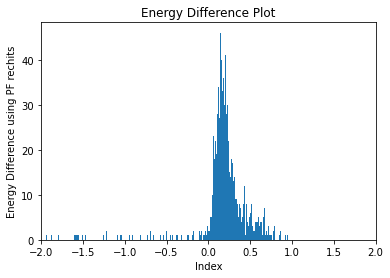

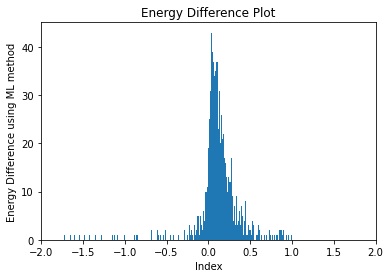

In [41]:
#### plot the diff of energy hists
# Plot the array
plt.hist(energyDiff_pf_array, bins=1000, range=(-3, 3))

# Set the x-axis range
x_min = -2  # Minimum x-value
x_max = 2   # Maximum x-value
plt.xlim(x_min, x_max)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Energy Difference using PF rechits')
plt.title('Energy Difference Plot')

# Display the plot
plt.show()


plt.hist(energyDiff_ps_array, bins=1000, range=(-3, 3))

# Set the x-axis range
x_min = -2  # Minimum x-value
x_max = 2  # Maximum x-value
plt.xlim(x_min, x_max)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Energy Difference using ML method')
plt.title('Energy Difference Plot')

# Display the plot
plt.show()

In [42]:
from scipy.stats import norm
from scipy.optimize import curve_fit

[0.80872622 0.15708723 0.08832405]


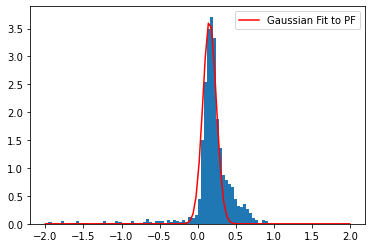

[0.80142977 0.07556633 0.09120073]


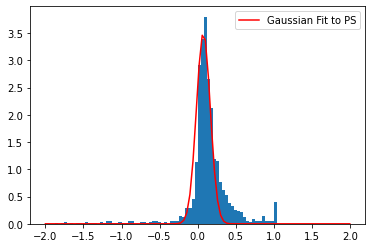

In [43]:
#### Fit both wigh Gaussian

bin_centers1, bin_edges1, _ = plt.hist(energyDiff_pf_array, bins=100, range=(-2, 2), density=True)
bin_width1 = bin_edges1[1] - bin_edges1[0]
#bin_centers = bin_centers * bin_width  # Scale the histogram values to match the area under the curve
bin_centers1 = bin_centers1  # Scale the histogram values to match the area under the curve
p0 = [1, 0.2, 0.08]  # Initial guess for the Gaussian parameters
#params, _ = curve_fit(gaussian, bin_edges[:-1], bin_centers, p0=p0)
params, _ = curve_fit(gaussian, bin_edges1[:-1], bin_centers1, p0=p0)

# Plot the fitted Gaussian curve
x = np.linspace(-2, 2, 100)
y = gaussian(x, *params)
plt.plot(x, y, 'r-', label='Gaussian Fit to PF')

print(params)
# Show the legend
plt.legend()

# Show the plot
plt.show()


bin_centers, bin_edges, _ = plt.hist(energyDiff_ps_array, bins=100, range=(-2, 2), density=True)
bin_width = bin_edges[1] - bin_edges[0]
#bin_centers = bin_centers * bin_width  # Scale the histogram values to match the area under the curve
bin_centers = bin_centers  # Scale the histogram values to match the area under the curve
p0 = [1, 0.2, 0.08]  # Initial guess for the Gaussian parameters
params, _ = curve_fit(gaussian, bin_edges[:-1], bin_centers, p0=p0)

# Plot the fitted Gaussian curve
x = np.linspace(-2, 2, 100)
y = gaussian(x, *params)
plt.plot(x, y, 'r-', label='Gaussian Fit to PS')

print(params)
# Show the legend
plt.legend()

# Show the plot
plt.show()

In [44]:
bin_midpoints = [(bin_edges1[i] + bin_edges1[i + 1]) / 2 for i in range(len(bin_edges1) - 1)]
rms_value1 = np.sqrt(np.sum(np.array(bin_midpoints)**2 * np.array(bin_centers1)) / len(bin_midpoints))
rms_value2 = np.sqrt(np.sum(np.array(bin_midpoints)**2 * np.array(bin_centers)) / len(bin_midpoints))

In [45]:
rms_value1

0.17321710121140488

In [46]:
rms_value2

0.16340936989429067